In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])

df = df.sort_values("datetime")
df = df.dropna()
df["price_tomorrow"] = df["price_EUR_MWh"].shift(-1)
df = df.dropna(subset=["price_tomorrow"])

In [2]:
all_features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
    "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
    "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
    "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
    "quantity_other", "quantity_MW"
]
# features = [
#     "wind_speed_180m", "wind_speed_120m", "quantity_biomass", "quantity_fossil_hard_coal", "quantity_waste",
#     "quantity_other", "quantity_MW", "quantity_wind_offshore"
# ]
features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other","quantity_MW"
]

df[features].dropna()
target = "price_EUR_MWh"


X = df[features]
y = df[target]

mask = X.notna().all(axis=1) & y.notna()

X = X[mask]
y = y[mask]

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [3]:

numeric_features = features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder="drop"
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])


cv_mae = -cross_val_score(
    model, X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)
print(f"5-fold CV MAE: {cv_mae.mean():.2f} ± {cv_mae.std():.2f}")

5-fold CV MAE: 92.36 ± 56.90


In [4]:
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test R² : {r2_score(y_test, y_pred):.3f}")


latest_features = X.tail(1)
tomorrows_price_estimate = model.predict(latest_features)[0]
print(f"Predicted price for {df.iloc[-1]['datetime'] + pd.Timedelta(days=1):%Y-%m-%d}: "
      f"{tomorrows_price_estimate:.2f}")

Test MAE: 48.74
Test R² : -0.239
Predicted price for 2025-06-23: 144.17


In [5]:
# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]

Test MAE: 48.74
Test R² : -0.239


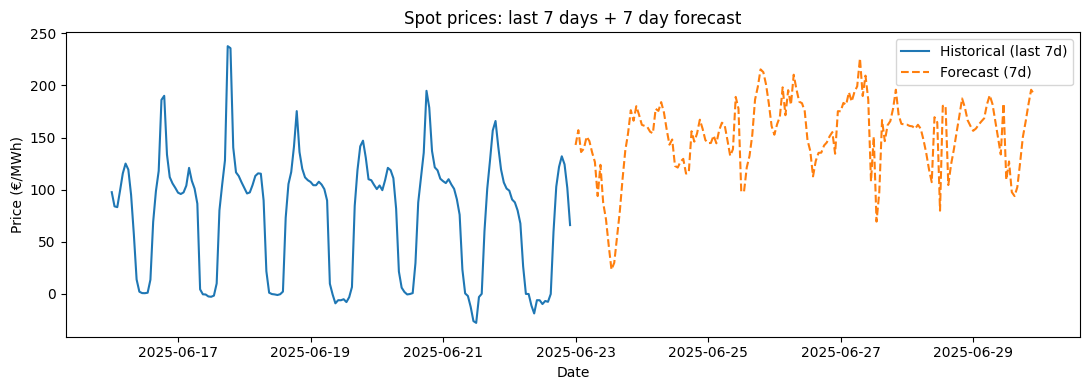

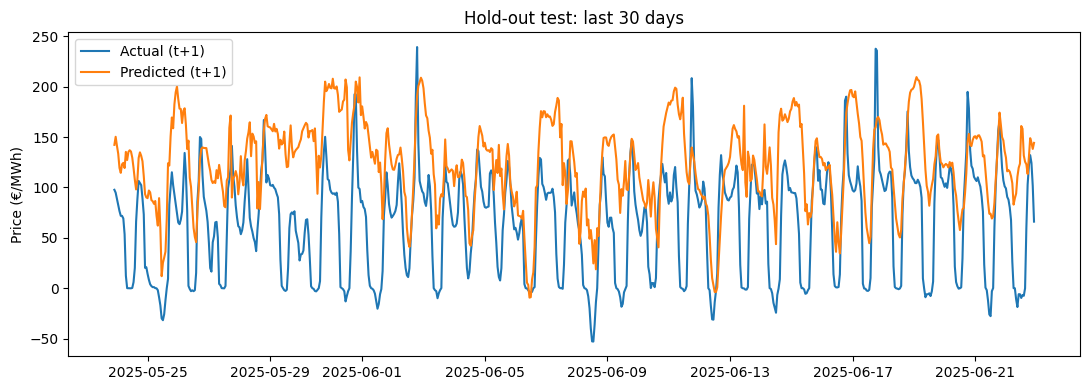

In [8]:

y_pred = model.predict(X_test)
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test R² : {r2_score(y_test, y_pred):.3f}")


HORIZON = 168                                     
future_dates = pd.date_range(df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
                             periods=HORIZON, freq="h")

forecast_df = pd.DataFrame(
    np.tile(X.tail(1).values, (HORIZON, 1)),
    columns=features
)
forecast_df["datetime"] = future_dates
forecast_df = (
    forecast_df
    .merge(weather_df[["datetime"] + weather_features],
           on="datetime", how="left", suffixes=("", "_fcst"))
)

for col in weather_features:                    
    forecast_df[col] = forecast_df[f"{col}_fcst"]
    forecast_df.drop(columns=f"{col}_fcst", inplace=True)

forecast_df = forecast_df.dropna()

forecast_df["predicted_price"] = model.predict(forecast_df[features])



forecast_start = forecast_df["datetime"].min()
hist_mask = (df["datetime"] >= forecast_start - pd.Timedelta(days=7)) & \
            (df["datetime"] <  forecast_start)

plt.figure(figsize=(11,4))
plt.plot(df.loc[hist_mask, "datetime"],
         df.loc[hist_mask, "price_EUR_MWh"],
         label="Historical (last 7d)")
plt.plot(forecast_df["datetime"],
         forecast_df["predicted_price"],
         linestyle="--",
         label="Forecast (7d)")
plt.xlabel("Date"); plt.ylabel("Price (€/MWh)")
plt.title("Spot prices: last 7 days + 7 day forecast")
plt.legend(); plt.tight_layout(); plt.show()


test_dates = df.loc[X_test.index, "datetime"]
test_res = pd.DataFrame({"datetime": test_dates,
                         "actual": y_test.values,
                         "pred":   y_pred})

end = test_res["datetime"].max()
mask = test_res["datetime"] >= end - pd.Timedelta(days=30)

plt.figure(figsize=(11,4))
plt.plot(test_res.loc[mask, "datetime"],
         test_res.loc[mask, "actual"],
         label="Actual (t+1)")
plt.plot(test_res.loc[mask, "datetime"],
         test_res.loc[mask, "pred"],
         label="Predicted (t+1)")
plt.ylabel("Price (€/MWh)")
plt.title("Hold-out test: last 30 days")
plt.legend(); plt.tight_layout(); plt.show()